In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import copy
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2
from tensorflow.keras import optimizers
import pickle
from numpy.linalg import norm

In [3]:
# load data
def data_loader(filepath,test_data = False):
    data = h5py.File(filepath, 'r')
    if test_data ==True:
      x_data = np.array(data['data'])[:500]
      y_data = np.array(data['label'])[:500]
      x_data = x_data.transpose((0,2,3,1))
      return x_data,y_data
    else:
      x_data = np.array(data['data'])
      y_data = np.array(data['label'])
      x_data = x_data.transpose((0,2,3,1))
      return x_data, y_data
      
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx
            

In [4]:
data_path="/content/drive/MyDrive/fine-pruning/data/Lab3"

clean_data_valid_filename = data_path+"/cl/valid.h5"
clean_data_test_filename = data_path+"/cl/test.h5"

bd_valid_filename = data_path+"/bd/bd_valid.h5"
bd_test_filename = data_path+"/bd/bd_test.h5"



In [ ]:
# cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)
# cl_x_test, cl_y_test = data_loader(clean_data_test_filename)

# bd_x_valid, bd_y_valid = data_loader(bd_valid_filename)
# bd_x_test, bd_y_test = data_loader(bd_test_filename)

KeyboardInterrupt: ignored

In [5]:
def get_norm(weights,ord):
  norm = []
  for i in range( weights.shape[3]):
    norm.append(tf.norm(weights[:,:,:,i],ord=ord).numpy())
  norm =np.array(norm)
  return norm,np.argsort(norm),np.mean(norm)



In [6]:
def finePruning(conv_layer_idx,B_path,B_weights_path,B_prime_path, B_prime_weights_path, lr, epochs, batch_size, percentChRemovedThreshold, clean_data_valid_filename,clean_data_test_filename,poisoned_data_test_filename =None,prune_method="l1norm",verbose=False):
  if prune_method not in {'l1norm', 'l2norm', 'apoz'}:
    raise ValueError('Invalid `pruning method`')

    # define optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=lr)
    # load baseline model
  B = keras.models.load_model(B_path)
  B.load_weights(B_weights_path)
    
    # define the B_prime model and initialize it with the same weights as B (initally it is the same as the baseline)
  B_prime = keras.models.load_model(B_path)
  B_prime.load_weights(B_weights_path)
    
   
  cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)
  cl_x_valid_t, cl_y_valid_t = data_loader(clean_data_valid_filename,test_data = True)


  cl_x_test, cl_y_test = data_loader(clean_data_test_filename,test_data = True)
  bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename,test_data= True)
    
        
    # evaluate the original model accuracy on the clean validation data
  cl_label_p_valid_orig = np.argmax(B_prime(cl_x_valid_t), axis=1)
  clean_accuracy_valid_orig = np.mean(np.equal(cl_label_p_valid_orig, cl_y_valid_t)) * 100

    # evaluate the original model accuracy on the clean test data
  cl_label_p_test_orig = np.argmax(B_prime(cl_x_test), axis=1)
  clean_accuracy_test_orig = np.mean(np.equal(cl_label_p_test_orig, cl_y_test)) * 100
  print("Clean validation accuracy before modification: {0:3.6f}".format(clean_accuracy_valid_orig))
  print("Clean test accuracy before modification: {0:3.6f}".format(clean_accuracy_test_orig))
  bd_label_p_test_orig = np.argmax(B_prime(bd_x_test), axis=1)
  asr_test_orig= np.mean(np.equal(bd_label_p_test_orig, bd_y_test)) * 100
  print("Attack success rate before modification: {0:3.6f}".format(asr_test_orig))
    
  convLayerWeights = B.layers[conv_layer_idx].get_weights()[0]
  convLayerBiases  = B.layers[conv_layer_idx].get_weights()[1]

  if prune_method == "l1norm":

      # get the activations and sort them in an increasing order excluding empty layers
      norms,allIdxToPrune,thresh = get_norm(convLayerWeights,ord = 1)
      idxToPrune = []
      for idx in allIdxToPrune :
        if norms[idx] < thresh:
          idxToPrune.append(idx)
      if verbose ==True :
        print(idxToPrune)
   
  elif prune_method == "l2norm":
      norms,allIdxToPrune,thresh = get_norm(convLayerWeights,ord = "euclidean")
      idxToPrune = []
      for idx in allIdxToPrune :
        if norms[idx] < thresh:
          idxToPrune.append(idx)
      if verbose ==True :
        print(idxToPrune)

  # elif prune_method == "apoz":
  #     layer=B_prime.layers[conv_layer_idx]
  #     norms = identify.get_apoz(B_prime, layer, bd_x_test)
  #     allIdxToPrune = np.argsort(norms)
  #     idxToPrune = identify.high_apoz(norms,method="both")

  res_shape = convLayerWeights.shape[3] + 1
    
  totalPercentChannelsRemoved = np.zeros((res_shape))
  totalCleanAccuracyValid = np.zeros((res_shape))
  totalAttackSuccessRateValid = np.zeros((res_shape))
  totalCleanAccuracyTest = np.zeros((res_shape))
  totalAttackSuccessRateTest = np.zeros((res_shape))
  percentValidationAccuracy = []

  iter = 0
    # before the fine pruning estimate the baseline clean validation/test accuracies:
  percentChannelsRemoved = 0 # no channel has been removed yet
  totalPercentChannelsRemoved[iter] = percentChannelsRemoved
  totalCleanAccuracyValid[iter] = clean_accuracy_valid_orig
  totalCleanAccuracyTest[iter] = clean_accuracy_test_orig
  totalAttackSuccessRateTest[iter] = asr_test_orig
  iter+=1

  for chIdx in allIdxToPrune:
        percentChannelsRemoved = iter / convLayerWeights.shape[3]
        if chIdx in idxToPrune:  # if not dormant
            # remove one channel at a time

            convLayerWeights[:, :, :, chIdx] = 0
            convLayerBiases[chIdx] = 0

            # update weights and biases of the badnet
            B_prime.layers[conv_layer_idx].set_weights([convLayerWeights, convLayerBiases])

            B_prime.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            print("Learning rate:", B_prime.optimizer.learning_rate.numpy())
            B_prime.fit(cl_x_valid, cl_y_valid, epochs=epochs, batch_size=batch_size,verbose=True)

            # evaluate the updated model predictions on the clean validation data
            cl_label_p_valid = np.argmax(B_prime(cl_x_valid_t), axis=1)
            clean_accuracy_valid = np.mean(np.equal(cl_label_p_valid, cl_y_valid_t)) * 100

            # evaluate the updated model accuracy on the clean test data
            cl_label_p_test = np.argmax(B_prime(cl_x_test), axis=1)
            clean_accuracy_test = np.mean(np.equal(cl_label_p_test, cl_y_test)) * 100

            if poisoned_data_test_filename:
                # evaluate the updated model model attack success rate on the test data
                bd_label_p_test = np.argmax(B_prime(bd_x_test), axis=1)
                asr_test = np.mean(np.equal(bd_label_p_test, bd_y_test)) * 100
            tf.keras.backend.clear_session()

            print(
                "Iteration = {0:3d}, channel removed = {1:3d}, percent channels removed = {2:3.6f}\nClean validation accuracy after modification: {3:3.6f}\n Clean test accuracy after modification: {4:3.6f}, attack success rate test =  {5:3.6f}".format(
                    iter, chIdx, percentChannelsRemoved * 100, clean_accuracy_valid, clean_accuracy_test, asr_test))
            totalPercentChannelsRemoved[iter] = percentChannelsRemoved
            totalCleanAccuracyValid[iter] = clean_accuracy_valid
            totalCleanAccuracyTest[iter] = clean_accuracy_test
            totalAttackSuccessRateTest[iter] = asr_test
        else:  # if dormant
            print(
                "Iteration = {0:3d}, channel removed = {1:3d}, percent channels removed = {2:3.6f}\nClean validation accuracy after modification: {3:3.6f}\n Clean test accuracy after modification: {4:3.6f}, attack success rate test =  {5:3.6f}".format(
                    iter, chIdx, percentChannelsRemoved * 100, clean_accuracy_valid, clean_accuracy_test, asr_test))

            totalPercentChannelsRemoved[iter] = percentChannelsRemoved
            totalCleanAccuracyValid[iter] = clean_accuracy_valid
            totalCleanAccuracyTest[iter] = clean_accuracy_test
            totalAttackSuccessRateTest[iter] = asr_test

        if percentChannelsRemoved*100>=percentChRemovedThreshold: #stop re-training when more than percentChRemovedThreshold% of channels are pruned
            break
        iter += 1

    # save the B' model
  B_prime.save(B_prime_path)
  B_prime.save_weights(B_prime_weights_path)
  return (totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)

In [7]:
model_path="/content/drive/MyDrive/fine-pruning/models"
cleanModel_path = model_path+"/bd_net.h5"
cleanModel_weights_path = model_path+"/bd_weights.h5"

backdoorModel_path = model_path+"/bd_net_tmp.h5"
backdoorModel_weights_path = model_path+"/bd_weights_tmp.h5"

In [8]:
lr = 1e-3
epochs = 10
batch_size = 32

conv_layer_idx = 1
prune_method = "l1norm"


In [9]:

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    

Clean validation accuracy before modification: 98.400000
Clean test accuracy before modification: 98.800000
Attack success rate before modification: 100.000000
[4, 16, 1, 2, 17, 12, 11, 0, 7, 6, 9, 13, 15]
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 4s 5ms/step - loss: 0.3065 - accuracy: 0.9464
Epoch 2/10
361/361 [==============================] - 2s 7ms/step - loss: 0.1154 - accuracy: 0.9729
Epoch 3/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1233 - accuracy: 0.9711
Epoch 4/10
361/361 [==============================] - 3s 7ms/step - loss: 0.1336 - accuracy: 0.9662
Epoch 5/10
361/361 [==============================] - 3s 7ms/step - loss: 0.1603 - accuracy: 0.9655
Epoch 6/10
361/361 [==============================] - 3s 9ms/step - loss: 0.1157 - accuracy: 0.9728
Epoch 7/10
361/361 [==============================] - 3s 9ms/step - loss: 0.0797 - accuracy: 0.9808
Epoch 8/10
361/361 [==============================] - 3s 7ms/step - loss:

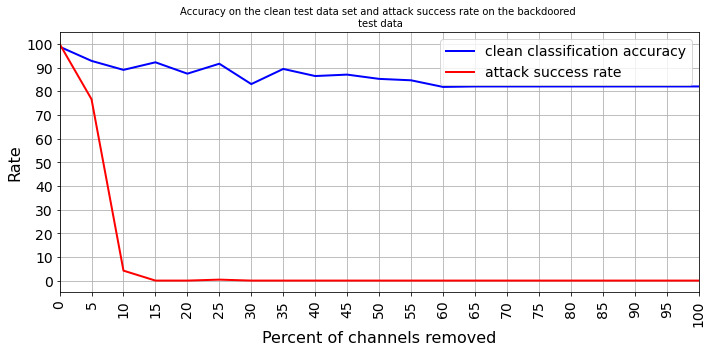

In [10]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 21,1))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

In [11]:
conv_layer_idx = 1
prune_method = "l2norm"

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    

Clean validation accuracy before modification: 98.400000
Clean test accuracy before modification: 98.800000
Attack success rate before modification: 100.000000
[4, 16, 1, 2, 17, 12, 11, 0, 7, 6, 13, 9, 15]
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 2s 5ms/step - loss: 0.2614 - accuracy: 0.9553
Epoch 2/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1288 - accuracy: 0.9722
Epoch 3/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1209 - accuracy: 0.9715
Epoch 4/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1036 - accuracy: 0.9764
Epoch 5/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1782 - accuracy: 0.9609
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0956 - accuracy: 0.9781
Epoch 7/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1284 - accuracy: 0.9715
Epoch 8/10
361/361 [==============================] - 2s 5ms/step - loss:

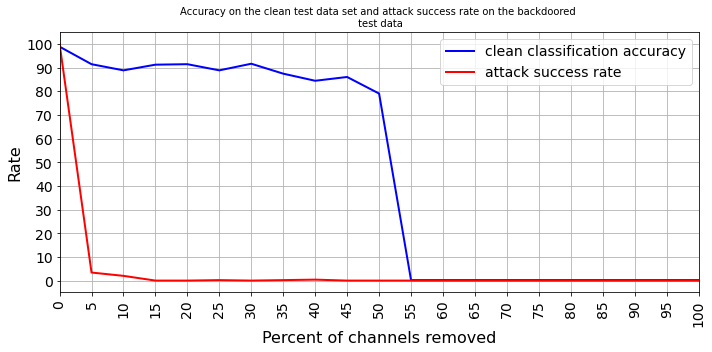

In [12]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 21,1))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

In [13]:
conv_layer_idx = 3
prune_method = "l1norm"

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    

Clean validation accuracy before modification: 98.400000
Clean test accuracy before modification: 98.800000
Attack success rate before modification: 100.000000
[9, 15, 27, 38, 14, 26, 1, 34, 11, 28, 17, 18, 35, 13, 24, 30, 36, 0, 37, 22, 4, 7, 12]
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 2s 5ms/step - loss: 0.2650 - accuracy: 0.9545
Epoch 2/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1381 - accuracy: 0.9692
Epoch 3/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1373 - accuracy: 0.9702
Epoch 4/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1162 - accuracy: 0.9708
Epoch 5/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0975 - accuracy: 0.9771
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1726 - accuracy: 0.9630
Epoch 7/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1221 - accuracy: 0.9706
Epoch 8/10
361/361 [===========

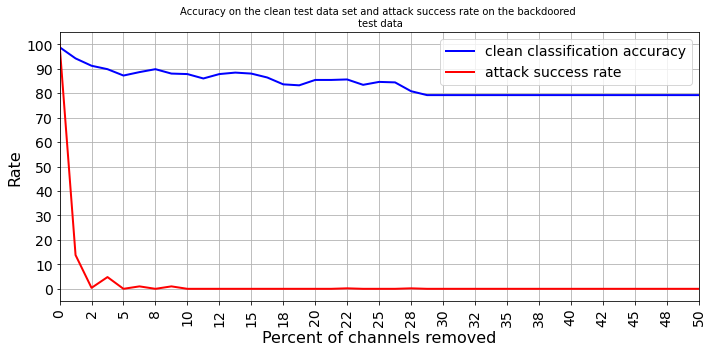

In [14]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 21,1))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

In [15]:
conv_layer_idx = 3
prune_method = "l2norm"

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    

Clean validation accuracy before modification: 98.400000
Clean test accuracy before modification: 98.800000
Attack success rate before modification: 100.000000
[9, 15, 38, 27, 14, 1, 26, 34, 11, 17, 18, 35, 28, 13, 36, 7, 0, 37, 24, 30, 4, 12, 22]
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 2s 5ms/step - loss: 0.2895 - accuracy: 0.9500
Epoch 2/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1075 - accuracy: 0.9742
Epoch 3/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1482 - accuracy: 0.9669
Epoch 4/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1322 - accuracy: 0.9695
Epoch 5/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0989 - accuracy: 0.9766
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1545 - accuracy: 0.9662
Epoch 7/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1065 - accuracy: 0.9738
Epoch 8/10
361/361 [===========

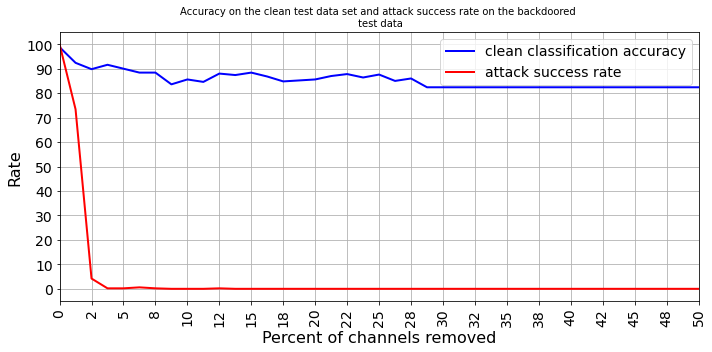

In [16]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 21,1))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

In [17]:
conv_layer_idx = 5
prune_method = "l1norm"

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    

Clean validation accuracy before modification: 98.400000
Clean test accuracy before modification: 98.800000
Attack success rate before modification: 100.000000
[17, 24, 53, 50, 38, 0, 14, 41, 48, 31, 34, 33, 49, 13, 45, 25, 15, 12, 30, 47, 37, 26, 36, 55, 40, 27, 9, 44, 2, 59]
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 2s 5ms/step - loss: 0.2846 - accuracy: 0.9526
Epoch 2/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0913 - accuracy: 0.9772
Epoch 3/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0973 - accuracy: 0.9768
Epoch 4/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1713 - accuracy: 0.9643
Epoch 5/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1332 - accuracy: 0.9682
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1002 - accuracy: 0.9758
Epoch 7/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0785 - accuracy: 0.9821
E

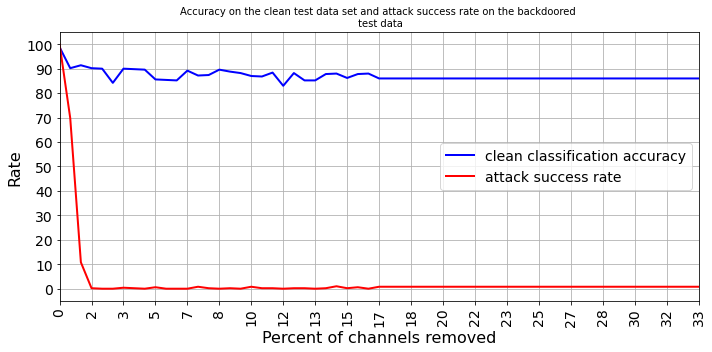

In [18]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 21,1))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

In [19]:
conv_layer_idx = 5
prune_method = "l2norm"

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    

Clean validation accuracy before modification: 98.400000
Clean test accuracy before modification: 98.800000
Attack success rate before modification: 100.000000
[17, 24, 53, 50, 38, 0, 14, 41, 48, 31, 34, 33, 49, 45, 15, 13, 25, 47, 26, 37, 12, 36, 30, 55, 9, 40, 27, 59, 2, 44]
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 2s 5ms/step - loss: 0.2732 - accuracy: 0.9576
Epoch 2/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1215 - accuracy: 0.9719
Epoch 3/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1575 - accuracy: 0.9643
Epoch 4/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1177 - accuracy: 0.9711
Epoch 5/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1640 - accuracy: 0.9634
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0868 - accuracy: 0.9802
Epoch 7/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1012 - accuracy: 0.9785
E

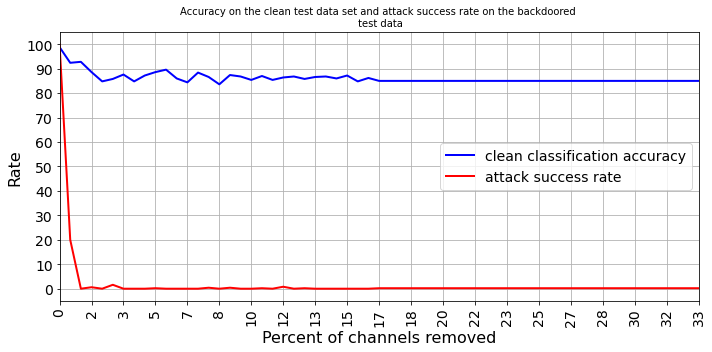

In [20]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 21,1))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

In [ ]:
!mkdir /content/l1norm/

In [ ]:
!mkdir /content/l2norm/

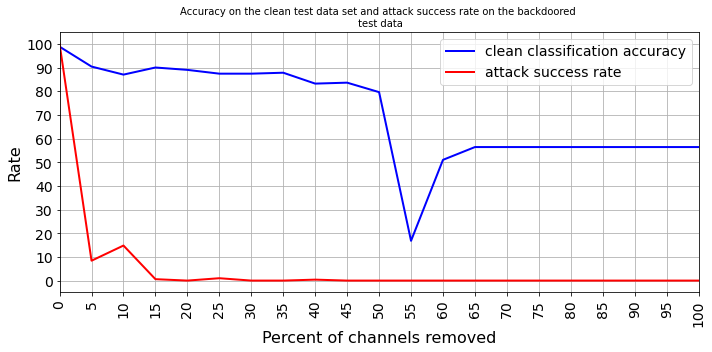

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 21,1))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

plt.savefig('/content/conv'+str(conv_layer_idx)+'-finePruning.png', dpi=400)

In [ ]:
conv_layer_idx = 1

prune_method = "l2norm"

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    


Clean validation accuracy before modification: 98.333333
Clean test accuracy before modification: 99.000000
Attack success rate before modification: 100.000000
[9, 15, 38, 27, 14, 1, 26, 34, 11, 17, 18, 35, 28, 13, 36, 7, 0, 37, 24, 30, 4, 12, 22]
Learning rate: 0.001
Epoch 1/10
361/361 [==============================] - 8s 15ms/step - loss: 0.2854 - accuracy: 0.9530
Epoch 2/10
361/361 [==============================] - 4s 12ms/step - loss: 0.1478 - accuracy: 0.9676
Epoch 3/10
361/361 [==============================] - 4s 12ms/step - loss: 0.0687 - accuracy: 0.9847
Epoch 4/10
361/361 [==============================] - 4s 12ms/step - loss: 0.1098 - accuracy: 0.9718
Epoch 5/10
361/361 [==============================] - 4s 12ms/step - loss: 0.1712 - accuracy: 0.9617
Epoch 6/10
361/361 [==============================] - 4s 12ms/step - loss: 0.0798 - accuracy: 0.9807
Epoch 7/10
361/361 [==============================] - 4s 12ms/step - loss: 0.1737 - accuracy: 0.9599
Epoch 8/10
361/361 [====

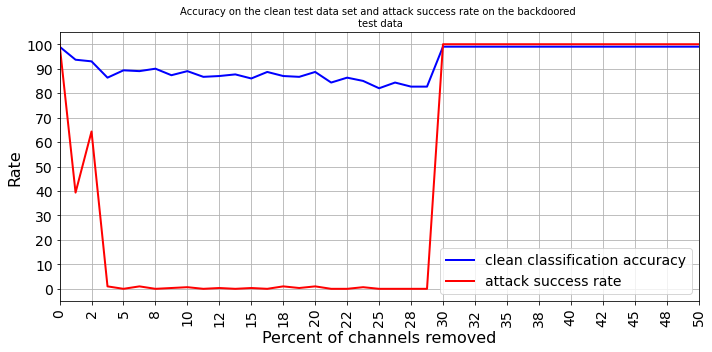

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 41,2))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

plt.savefig('/content/conv'+str(conv_layer_idx)+'-finePruning.png', dpi=400)

In [ ]:
conv_layer_idx = 1

prune_method = "l2norm"

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    


In [ ]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 41,1))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

plt.savefig('/content/conv'+str(conv_layer_idx)+'-finePruning.png', dpi=400)

In [ ]:
conv_layer_idx = 5

prune_method = "l1norm"

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 41,2))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

plt.savefig('/content/conv'+str(conv_layer_idx)+prune_method+'-finePruning.png', dpi=400)

Clean validation accuracy before modification: 98.649000
Clean test accuracy before modification: 98.700000
Attack success rate before modification: 100.000000
[9, 15, 27, 38, 14, 26, 1, 34, 11, 28, 17, 18, 35, 13, 24, 30, 36, 0, 37, 22, 4, 7, 12]
Learning rate: 0.001
Epoch 1/3
361/361 [==============================] - 3s 5ms/step - loss: 0.2644 - accuracy: 0.9504
Epoch 2/3
361/361 [==============================] - 2s 5ms/step - loss: 0.1215 - accuracy: 0.9733
Epoch 3/3
361/361 [==============================] - 2s 5ms/step - loss: 0.1231 - accuracy: 0.9722
Iteration =   1, channel removed =   9, percent channels removed = 2.500000
Clean validation accuracy after modification: 97.731012
 Clean test accuracy after modification: 93.800000, attack success rate test =  98.900000
Learning rate: 0.001
Epoch 1/3
361/361 [==============================] - 2s 5ms/step - loss: 0.1967 - accuracy: 0.9568
Epoch 2/3
361/361 [==============================] - 2s 5ms/step - loss: 0.0758 - accuracy: 

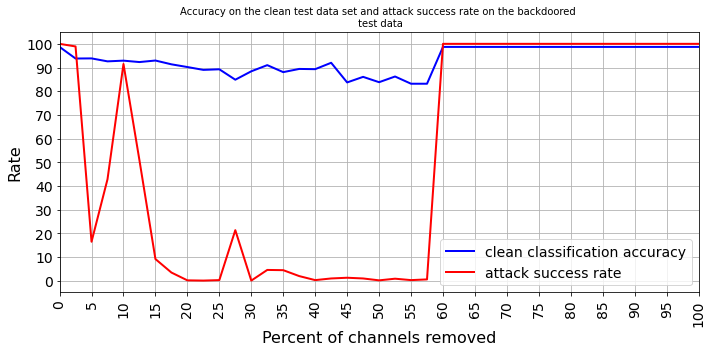

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 41,2))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

plt.savefig('/content/conv'+str(conv_layer_idx)+prune_method+'-finePruning.png', dpi=400)

Clean validation accuracy before modification: 98.649000
Clean test accuracy before modification: 98.700000
Attack success rate before modification: 100.000000
[17, 24, 53, 50, 38, 0, 14, 41, 48, 31, 34, 33, 49, 45, 15, 13, 25, 47, 26, 37, 12, 36, 30, 55, 9, 40, 27, 59, 2, 44]
Learning rate: 0.001
Epoch 1/3
361/361 [==============================] - 2s 5ms/step - loss: 0.2883 - accuracy: 0.9507
Epoch 2/3
361/361 [==============================] - 2s 5ms/step - loss: 0.1185 - accuracy: 0.9738
Epoch 3/3
361/361 [==============================] - 2s 5ms/step - loss: 0.0996 - accuracy: 0.9758
Iteration =   1, channel removed =  17, percent channels removed = 1.666667
Clean validation accuracy after modification: 98.389192
 Clean test accuracy after modification: 95.800000, attack success rate test =  57.900000
Learning rate: 0.001
Epoch 1/3
361/361 [==============================] - 2s 5ms/step - loss: 0.1877 - accuracy: 0.9610
Epoch 2/3
361/361 [==============================] - 2s 5ms/st

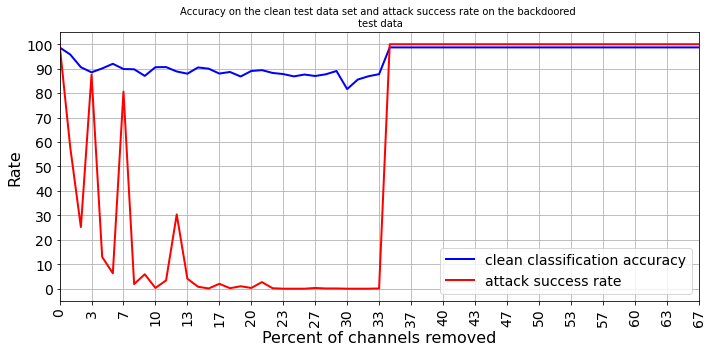

In [ ]:
conv_layer_idx = 5

prune_method = "l2norm"

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 41,2))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

plt.savefig('/content/conv'+str(conv_layer_idx)+prune_method+'-finePruning.png', dpi=400)

Clean validation accuracy before modification: 98.649000
Clean test accuracy before modification: 98.700000
Attack success rate before modification: 100.000000
[17, 24, 53, 50, 38, 0, 14, 41, 48, 31, 34, 33, 49, 13, 45, 25, 15, 12, 30, 47, 37, 26, 36, 55, 40, 27, 9, 44, 2, 59]
Learning rate: 0.001
Epoch 1/3
361/361 [==============================] - 2s 5ms/step - loss: 0.2474 - accuracy: 0.9575
Epoch 2/3
361/361 [==============================] - 2s 5ms/step - loss: 0.1174 - accuracy: 0.9736
Epoch 3/3
361/361 [==============================] - 2s 5ms/step - loss: 0.1447 - accuracy: 0.9678
Iteration =   1, channel removed =  17, percent channels removed = 1.666667
Clean validation accuracy after modification: 97.731012
 Clean test accuracy after modification: 93.150000, attack success rate test =  100.000000
Learning rate: 0.001
Epoch 1/3
361/361 [==============================] - 2s 5ms/step - loss: 0.1964 - accuracy: 0.9564
Epoch 2/3
361/361 [==============================] - 2s 5ms/s

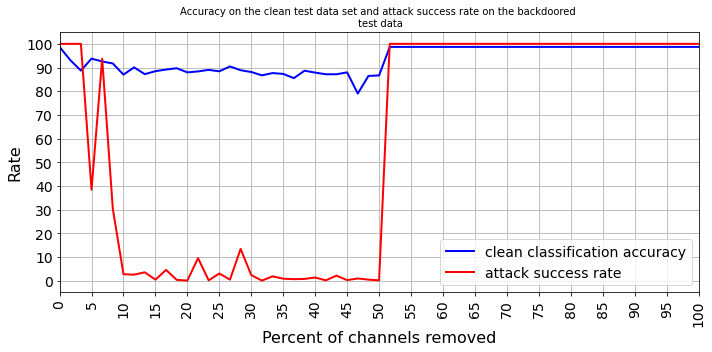

In [ ]:
conv_layer_idx = 5

prune_method = "l1norm"

(totalPercentChannelsRemoved,totalCleanAccuracyValid,totalCleanAccuracyTest,totalAttackSuccessRateTest)=finePruning(conv_layer_idx,cleanModel_path,cleanModel_weights_path,
                                                                                                                    backdoorModel_path,backdoorModel_weights_path,
                                                                                                                    lr, epochs, batch_size, 100, 
                                                                                                                    clean_data_valid_filename,clean_data_test_filename, 
                                                                                                                    bd_test_filename,
                                                                                                                    prune_method=prune_method,
                                                                                                                    verbose=True)
    
fig, axs = plt.subplots(figsize=(10, 5))
xticks = [str("%.0f" % (x * 100)) for x in totalPercentChannelsRemoved]
xticks = np.asarray(xticks)[list(range(0, 61,3))]
axs.set_yticks(np.arange(0, 101, 10))
axs.set_xticks(np.arange(0, 1.001, 0.05))
axs.set_xticklabels(xticks, rotation=90)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_ylabel('Rate', fontsize=16)
axs.set_xlabel('Percent of channels removed', fontsize=16)
axs.set_xlim([0, 1])
axs.plot(totalPercentChannelsRemoved, totalCleanAccuracyTest, 'b-', linewidth=2,
         label="clean classification accuracy")
axs.set_title("Accuracy on the clean test data set and attack success rate on the backdoored \n test data",fontsize=10)
axs.plot(totalPercentChannelsRemoved, totalAttackSuccessRateTest, 'r-', linewidth=2, label='attack success rate')
font = font_manager.FontProperties(size=14)
axs.legend(loc='best', prop=font)
plt.grid()
fig.tight_layout()

plt.savefig('/content/conv'+str(conv_layer_idx)+prune_method+'-finePruning.png', dpi=400)

ANALYSING THE WEIGHTS

In [ ]:
conv_layer_idx=[1,3,5]


3

In [ ]:
B.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [ ]:
layer_weights=B.get_layer('conv_1').get_weights()

In [ ]:
B.layers[1].kernel

In [ ]:
layer_weights[0][0][0].shape

(3, 20)

In [ ]:
def get_l2norm(weight):

    weights_dict={}
    num_filters=len(weight[0,0,0,:])

    for j in range(num_filters):
      w_s = tf.norm(weight[:,:,:,j],ord='euclidean').numpy()
      filt = j
      weights_dict[filt] = w_s

    activationsByChannelsBeforeTrain = np.array(list(weights_dict.values()),dtype='float32')
    
    return activationsByChannelsBeforeTrain

In [ ]:
layer_weights[0].shape[-1]

20

Layerwise norm

In [ ]:
norms=[]
for i in range(layer_weights[0].shape[-1]):
  norms.append(tf.norm(layer_weights[0][:,:,:,i],ord="euclidean").numpy())

In [ ]:
thresh=np.array(norms).mean()

In [ ]:
tf.norm(layer_weights[0][0][0][0],ord="euclidean").numpy()


In [ ]:
layer_weights[0][0][0][0]=0

In [ ]:
layer_weights[0][0][0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [ ]:
kernels_pruned=0
for i in range(20):
  if thresh <norms[i]:
    layer_weights[0][:,:,:,i]=0
    kernels_pruned +=1



In [ ]:
kernels_pruned

7

In [ ]:
tf.norm(layer_weights[0],ord="euclidean").numpy() # layerthreshold

2.0188012

In [ ]:
tf.norm(layer_weights[0][0][0][0],ord="euclidean").numpy()

0.2458606

In [ ]:
tf.norm(layer_weights[0][0][0][1],ord="euclidean").numpy()

0.20125106

In [ ]:
tf.norm(layer_weights[0][0][0][2],ord="euclidean").numpy()


0.30725437

In [ ]:
tf.norm(layer_weights[0][0][0][3],ord="euclidean").numpy()


IndexError: ignored

In [ ]:
def calculate_l2norm(matrix):
  return tf.norm(matrix,ord="euclidean").numpy()


In [ ]:
for i in range(20):
  print(calculate_l2norm(layer_weights[0][0][0][i]))

  

0.2458606
0.20125106
0.30725437


IndexError: ignored

In [ ]:
layer_weights[0][0][0][2].shape[0]

20

In [ ]:
layer_weights

[array([[[[-2.71882098e-02, -1.47099523e-02, -1.81758124e-03,
           -8.61967430e-02, -2.77063064e-03,  6.35011680e-03,
           -5.28782904e-02, -4.94118184e-02, -1.66969419e-01,
           -3.06105111e-02, -7.69208744e-02, -2.26289406e-02,
           -1.03140762e-03, -5.48905022e-02, -5.24314828e-02,
           -4.86391932e-02, -1.54415779e-02,  1.89116181e-04,
            4.02963161e-02, -3.92074548e-02],
          [-1.02435648e-02, -2.21055504e-02,  1.82134956e-02,
           -5.25131561e-02, -4.66468453e-04, -7.88844526e-02,
            8.50585103e-03, -4.14853171e-02, -1.16794504e-01,
           -2.87428219e-02, -8.40177611e-02, -2.23282222e-02,
           -3.24700512e-02,  3.95454131e-02, -3.84465642e-02,
           -4.65714596e-02, -7.61526870e-03, -1.60374697e-02,
            1.38726896e-02, -2.28485279e-03],
          [-2.20576040e-02, -5.19746635e-03, -1.45537676e-02,
           -1.17626444e-01, -1.33462984e-03, -8.22268352e-02,
            4.52473424e-02, -6.41085804e